<a href="https://colab.research.google.com/github/rcdavid1/dummy/blob/main/company25_in_class_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Dictionary

| Column Name | Description |
| :--- | :--- |
| **counterparty** | Name of the customer or business partner |
| **counterpartyidentifier** | Unique identifier code for the customer |
| **typeofsale** | Indicates whether the transaction is a "Sale" or "Return" |
| **documentnumber** | Invoice number |
| **invoicedate** | Date when the invoice was created |
| **referenceorder** | Sales order reference |
| **productnumber** | Product identifier |
| **productdescription** | Text description of the product |
| **productgroup** | Product group (highest level of grouping) |
| **productline** | Product line |
| **vendorproductnumber** | Vendor's reference number for the product |
| **manufacturer** | Name of the product manufacturer |
| **unitofmeasure** | Standardized unit of measure |
| **quantity** | Amount of product sold, rounded to 2 decimal places |
| **unit_price** | Price per unit, rounded to 2 decimal places |
| **unit_price_currency** | Currency code for the price (e.g., USD) |
| **total** | Calculated total value (quantity × unit price), rounded to 2 decimal places |
| **shiptoidentifier** | Ship-to identifier |
| **shiptoname** | Name of the ship-to location |
| **shiptostate** | State code of shipping destination |
| **shiptocounty** | Country code of shipping destination |
| **shipfromidentifier** | Plant/terminal identifier where product shipped from |
| **shipfromname** | Name of the shipping origin facility |
| **shipfromstate** | State code of shipping origin |
| **shipfromcounty** | Country code of shipping origin |

# Client's Description of Data and Request
* The dataset comprises sales information across all product groups for the calendar years 2021 to 2023.
* It includes details on product groups and product lines, facilitating product categorization. Although the data is anonymized, it effectively illustrates the seasonality of the agriculture cycle across all product groups.

## Download and Decrypt Data

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
sys.path.append('/content')

# Check if the directory exists before cloning
if not os.path.exists('company25_utils'):
    !git clone https://github.com/bsheese/company25_utils.git

from company25_utils.utils import download_and_decrypt_data

download_and_decrypt_data()

Downloading...
From (original): https://drive.google.com/uc?id=1omHwvtL4r1OGSUR12Th3RBpVliFxcnww
From (redirected): https://drive.google.com/uc?id=1omHwvtL4r1OGSUR12Th3RBpVliFxcnww&confirm=t&uuid=36b027f7-c120-4ebb-aa01-3612f3e4a6d1
To: /home/rdavid1/dummy/encrypted_data.enc
100%|██████████| 287M/287M [00:31<00:00, 9.19MB/s] 


Enter the password to decrypt the file:  ········


File decrypted successfully and saved as 'decrypted_data_file.csv'
The SHA-256 hash of encrypted_data.enc is:
f0fbaf55fadde70058539049d00b89fd5c00e5d1c68da30e3db57df937b87ac3


True

# Create Dataframe

## Initial Cleanup

In [10]:
import pandas as pd
df = pd.read_csv(r'decrypted_data_file.csv')
df.columns = df.columns.str.lower()

# shiptocounty and shipfromcounty, are monotonic (always US) and are dropped
df = df.drop(columns=['shiptocounty', 'shipfromcounty'])

# convert invoicedate to datetime, there is no hours, minutes, seconds, so only the date is extracted
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

# resolving the single issues using CAD by coverting to USD
cad_mask = df.unit_price_currency == 'CAD'
print(f'# of rows with CAD: {cad_mask.sum()}')
cad_value = df.loc[cad_mask, 'unit_price'].values[0]
cad_date = df.loc[cad_mask, 'invoicedate'].values[0]

df.loc[cad_mask, 'unit_price'] = df.loc[cad_mask, 'unit_price'] * .78351  # the actual coversion is done here, the rest is just for display purposes
df = df.drop(columns = 'unit_price_currency')

# of rows with CAD: 1


# Your Code Starts Here

# Question: Do certain product groups have higher rates of returns?

In [11]:
# quick look into given df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032873 entries, 0 to 1032872
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   counterparty            1032873 non-null  int64         
 1   counterpartyidentifier  1032873 non-null  object        
 2   typeofsale              1032873 non-null  object        
 3   documentnumber          1032873 non-null  int64         
 4   invoicedate             1032873 non-null  datetime64[ns]
 5   referenceorder          1032873 non-null  int64         
 6   productnumber           1032873 non-null  int64         
 7   productdescription      1032873 non-null  object        
 8   productgroup            1032873 non-null  object        
 9   productline             1032873 non-null  object        
 10  unitofmeasure           1032873 non-null  object        
 11  quantity                1032873 non-null  float64       
 12  unit_price    

In [12]:
# creating new df with columns of interest
df_int = df[["typeofsale", "productdescription", "productgroup", "total", "quantity"]]

df_int.info()

# checking na values
df_int.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032873 entries, 0 to 1032872
Data columns (total 5 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   typeofsale          1032873 non-null  object 
 1   productdescription  1032873 non-null  object 
 2   productgroup        1032873 non-null  object 
 3   total               1032873 non-null  float64
 4   quantity            1032873 non-null  float64
dtypes: float64(2), object(3)
memory usage: 39.4+ MB


typeofsale            0
productdescription    0
productgroup          0
total                 0
quantity              0
dtype: int64

Total Sale Transactions: 967789
Total Return Transactions: 65084


Text(0, 0.5, 'Product Group')

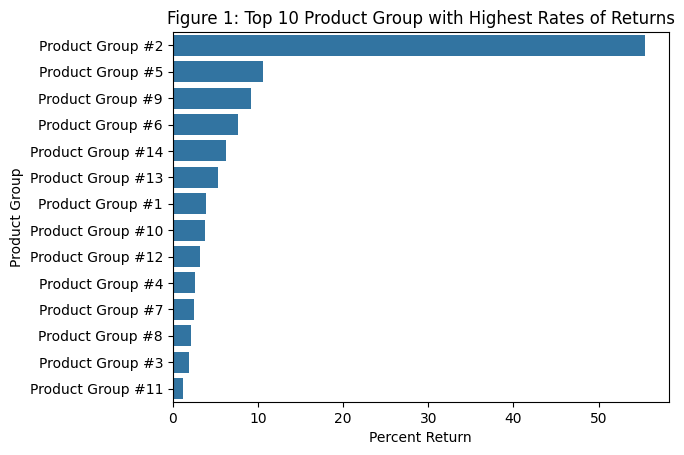

In [79]:
# creating two separate dfs for returns and sales
sales = df_int[df_int["typeofsale"] == "Sale"]
returns = df_int[df_int["typeofsale"] == "Return"]

# checking length of given df
print(f"Total Sale Transactions: {len(sales)}")
print(f"Total Return Transactions: {len(returns)}")

# exploring product groups and aggregating
sales_agg = sales.groupby("productgroup")["total"].agg(["count", "sum"])
sales_agg.columns = ["salescount", "salessum"]

returns_agg = returns.groupby("productgroup")["total"].agg(["count", "sum"])
returns_agg.columns = ["returnscount", "returnssum"]

# joining agg df
agg = sales_agg.join(returns_agg, how = "left").reset_index()

# calculating the rate of returns
agg["percentreturn"] = (agg["returnscount"] / agg["salescount"]) * 100

# visualizing rate of returns
top10 = agg.sort_values("percentreturn", ascending = False) 
sns.barplot(data = top10, x = "percentreturn", y = "productgroup")

# adjusting plot and axes titles
plt.title("Figure 1: Top 10 Product Group with Highest Rates of Returns")
plt.xlabel("Percent Return")
plt.ylabel("Product Group")


In [80]:
agg

,productgroup,salescount,salessum,returnscount,returnssum,percentreturn
0,Product Group #1,28611,1.154114e+08,1114,-8.198794e+06,3.893607
1,Product Group #10,63183,1.244189e+09,2421,-2.943666e+07,3.831727
2,Product Group #11,8941,4.405001e+07,110,-4.706405e+05,1.230287
3,Product Group #12,4215,3.600083e+05,137,-9.729576e+04,3.250297
4,Product Group #13,677,9.070243e+05,36,-2.374053e+04,5.317578
5,Product Group #14,48,1.585690e+05,3,-1.691000e+04,6.250000
6,Product Group #2,59801,1.762833e+08,33174,-2.482124e+08,55.473989
7,Product Group #3,75446,6.926445e+08,1446,-1.198283e+07,1.916603
8,Product Group #4,26949,3.409588e+07,690,-2.437003e+06,2.560392
9,Product Group #5,73627,1.984867e+09,7760,-4.805452e+08,10.539612


## Key Findings from Return Rate Analysis

Figure 1 shows the top 10 product groups by return rate, with Product Group #2 standing out dramatically at approximately 55% returns, dwarfing the other groups.. Product Groups #5, #9, and #6 show moderate return rates between 8-11%, while the remaining groups have relatively low return rates under 6%. The substantial gap between Product Group #2 and all others suggests a specific, systemic issue worth investigating.

Given that Product Group #2's return rate is nearly 5x higher than the next highest group, I will conduct a deeper analysis.

# Diving Deeping into Product Group # 2

In [38]:
# creating df for pg2
pg2 = df_int[df["productgroup"] == "Product Group #2"]

# viewing basic df info and na values
print(pg2.info())
print(f"\nMissing Values\n{pg2.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
Index: 92975 entries, 10 to 1032866
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   typeofsale          92975 non-null  object 
 1   productdescription  92975 non-null  object 
 2   productgroup        92975 non-null  object 
 3   total               92975 non-null  float64
 4   quantity            92975 non-null  float64
dtypes: float64(2), object(3)
memory usage: 4.3+ MB
None

Missing Values
typeofsale            0
productdescription    0
productgroup          0
total                 0
quantity              0
dtype: int64


/tmp/ipykernel_1308536/1850094815.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pg2, x='typeofsale', y='total', ax=axes[0], palette=['red', 'green'])
/tmp/ipykernel_1308536/1850094815.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pg2, x='typeofsale', y='quantity', ax=axes[1], palette=['red', 'green'])


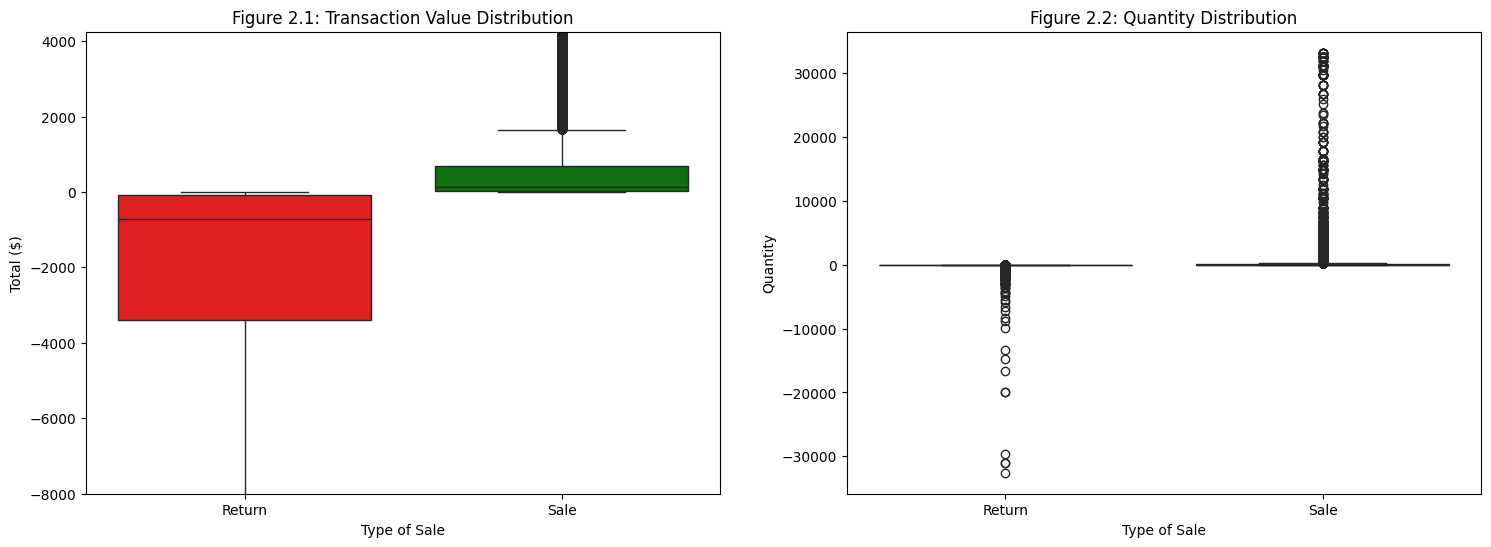

In [76]:
# Filter to Product Group #2
pg2 = df_int[df_int["productgroup"] == "Product Group #2"]

# Create side-by-side boxplots for both metrics
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Transaction Value
sns.boxplot(data=pg2, x='typeofsale', y='total', ax=axes[0], palette=['red', 'green'])
axes[0].set_title("Figure 2.1: Transaction Value Distribution")
axes[0].set_xlabel("Type of Sale")
axes[0].set_ylabel("Total ($)")
axes[0].set_ylim(pg2['total'].quantile(0.05), pg2['total'].quantile(0.95))  # Remove extreme outliers

# Plot 2: Quantity
sns.boxplot(data=pg2, x='typeofsale', y='quantity', ax=axes[1], palette=['red', 'green'])
axes[1].set_title("Figure 2.2: Quantity Distribution")
axes[1].set_xlabel("Type of Sale")
axes[1].set_ylabel("Quantity")

plt.show()

## Product Group #2 Deep Dive Analysis

Figure 2 reveals important patterns in Product Group #2's transaction characteristics. The transaction value distribution (left panel) shows that returns typically involve lower dollar amounts compared to sales, with return values centered around -$500 while sales center around $200. This suggests customers are more likely to return lower-value items from this product group.

The quantity distribution (right panel) indicates most transactions involve small quantities, but there are significant outliers representing bulk orders of 30,000+ units. These large-quantity outliers likely represent wholesale or distributor-level transactions. The presence of bulk returns could dramatically inflate the overall return rate despite representing only a small number of individual transactions.

The high 55% return rate observed in Figure 1 appears driven by both frequent small-value returns and occasional large-quantity bulk returns. This suggests the company should investigate retail customer satisfaction for small purchases and review wholesale return policies. Addressing these two distinct return patterns could significantly reduce Product Group #2's elevated return rate.